# Quickstart

Run the pipeline end-to-end and inspect the tuned results.

In [1]:
import json
import sys
import subprocess
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / 'data' / 'network_dataset_labeled.csv'
print('Project root:', PROJECT_ROOT)
print('Data path:', DATA_PATH)


Project root: D:\!Project\network-kpi-anomaly-system_agent
Data path: D:\!Project\network-kpi-anomaly-system_agent\data\network_dataset_labeled.csv


In [2]:
if not DATA_PATH.exists():
    raise FileNotFoundError('Dataset not found. Set DATA_PATH to your labeled CSV.')

df = pd.read_csv(DATA_PATH)
print('Rows:', len(df), 'Cols:', len(df.columns))
print('Anomaly rate:', df['anomaly'].mean() if 'anomaly' in df.columns else 'missing')


Rows: 1001 Cols: 21
Anomaly rate: 0.08291708291708291


Run model comparison and tuning (skips if artifacts already exist).

In [3]:
FORCE_RERUN = False


def latest_run(pattern):
    runs = sorted((PROJECT_ROOT / 'artifacts').glob(pattern))
    return runs[-1] if runs else None


def run_if_needed(pattern, cmd):
    if FORCE_RERUN or latest_run(pattern) is None:
        subprocess.run([sys.executable, '-m', cmd], check=True, cwd=PROJECT_ROOT)


run_if_needed('run_timecv_models_*', 'src.timecv_models')
run_if_needed('run_timecv_tune_gb_*', 'src.timecv_tune_gb')


## Results

In [4]:
import pandas as pd

models_run = latest_run('run_timecv_models_*')
if models_run is None:
    raise FileNotFoundError('No run_timecv_models_* artifacts found.')

summary = json.loads((models_run / 'metrics_summary.json').read_text(encoding='utf-8'))
rows = []
for model, metrics in summary['models'].items():
    rows.append({
        'model': model,
        'precision': f"{metrics['precision']['mean']:.4f} +/- {metrics['precision']['std']:.4f}",
        'recall': f"{metrics['recall']['mean']:.4f} +/- {metrics['recall']['std']:.4f}",
        'f2': f"{metrics['f2']['mean']:.4f} +/- {metrics['f2']['std']:.4f}",
        'pr_auc': f"{metrics['pr_auc']['mean']:.4f} +/- {metrics['pr_auc']['std']:.4f}",
    })

pd.DataFrame(rows)


,model,precision,recall,f2,pr_auc
0,LogisticRegression,0.2835 +/- 0.1706,0.6122 +/- 0.3180,0.4781 +/- 0.2405,0.6632 +/- 0.0173
1,RandomForest,0.3815 +/- 0.1536,0.4178 +/- 0.2963,0.3459 +/- 0.1271,0.4806 +/- 0.0317
2,GradientBoosting,0.6325 +/- 0.1319,0.8133 +/- 0.2225,0.7422 +/- 0.1593,0.8592 +/- 0.0511


In [5]:
tune_run = latest_run('run_timecv_tune_gb_*')
if tune_run is None:
    raise FileNotFoundError('No run_timecv_tune_gb_* artifacts found.')

best_cfg = json.loads((tune_run / 'best_config.json').read_text(encoding='utf-8'))
ops = json.loads((tune_run / 'operating_points.json').read_text(encoding='utf-8'))

print('Best config:')
print({k: best_cfg[k] for k in ['n_estimators','learning_rate','max_depth','min_samples_leaf','subsample']})

ops_table = pd.DataFrame([
    {
        'name': name,
        'threshold': f"{v['threshold']:.4f}",
        'precision': f"{v['precision']:.4f}",
        'recall': f"{v['recall']:.4f}",
        'f2': f"{v['f2']:.4f}",
        'alerts_per_1000': f"{v['alerts_per_1000']:.1f}",
    }
    for name, v in ops.items()
])
ops_table


Best config:
{'n_estimators': 100.0, 'learning_rate': 0.1, 'max_depth': 2.0, 'min_samples_leaf': 5.0, 'subsample': 0.85}


,name,threshold,precision,recall,f2,alerts_per_1000
0,f2_opt,0.0255,0.4762,0.9434,0.7886,140.0
1,high_recall,0.0352,0.5102,0.9434,0.8065,130.7
2,alert_budget_5p,0.8509,1.0000,0.3962,0.4506,28.0


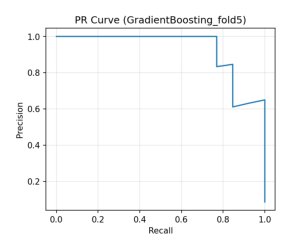

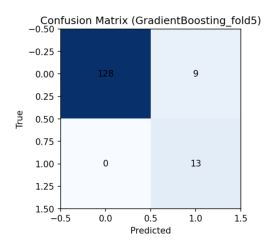

In [6]:
import matplotlib.pyplot as plt

pr_plot = models_run / 'pr_curve_GradientBoosting_fold5.png'
cm_plot = models_run / 'confusion_matrix_GradientBoosting_fold5.png'

for p in [pr_plot, cm_plot]:
    if p.exists():
        img = plt.imread(p)
        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.axis('off')
    else:
        print('Missing plot:', p)


Next

To explore alerts interactively:
```
streamlit run src/dashboard.py
```
